<a href="https://colab.research.google.com/github/NicoGol/FavoriteToys/blob/master/migration_gti_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploiting Google Trends data with AI algorithms to study migration #


## Research question ##

The purpose is two-folds :

* does adding Google Trends enhance the performance?
* does using LSTM enhance the performance?


Please run the following cell to load all the packages required for this notebook.

In [0]:
import keras.backend as kb
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from matplotlib import pyplot as plt

## Data set ##
As a starter, we first preprocess the data. We have basically two types of sequential data spanning from 2004 to 2014 : 
* Economic and demographic data, e.g. GDP, population size, migration numbers
* Google Trends Index, as defined in [1]

### Pre-processing ###

The preprocessing is done in two steps : 

* We first convert stata bilateral data from [1] into a simpler dataframe
* We normalize for the LSTM 


In [0]:
# @data: dataframe from the stata
# @returns : another dframe, each row is serie : a pair id dst-origin, e.g AUS-AUT where the columns are :
#         'origin' : code iso3 for the origin country 
#         'dest' : code iso3 for the origin country
#         'year' : the list of years for which we have migration data flow between the 2 countries
#         'language' : the part of the population of the origin country speaking French/Spanish/English
#         'control_var' : for each year it contains the different control variables on the countries of origin and destination (population, GDP, ...)
#         'GTI' : for each year it contains the non-normalized GTI values (uni and bi) for the different keywords
#         'fixed_effects' : the one-hot vectors representing the country of origin, of destination and the year of the data
#         'y' : the output value the LSTM will try to predict
#         'tot_mig' :  the non-normalized migration flow between the 2 countries for each year
#         'internet' : the part of the population of the origin country having acess to internet 
# @use_log : use the log value instead of the total value for the output and for the control variables
# @fixed_effects_origin/dest/year : use origin, dest and year fixed effects? (use maybe year since GT discontinuity from January 2011)
def getDataLSTM(oldData,fixed_effects_origin=True,fixed_effects_dest=True,fixed_effects_year=True,use_log=False):
    data = oldData.copy()
    list_origins = list(dict.fromkeys(data['iso3_o']))
    list_dests = list(dict.fromkeys(data['iso3_d']))
    list_years = list(dict.fromkeys(data['year']))
    def addFixed_effects(row):
        Xfixed_effects = []
        if fixed_effects_origin:
            fx_o = [0.] * len(list_origins)
            fx_o[list_origins.index(row['iso3_o'])] = 1.
            Xfixed_effects += fx_o
        if fixed_effects_dest:
            fx_d = [0.] * len(list_dests)
            fx_d[list_dests.index(row['iso3_d'])] = 1.
            Xfixed_effects += fx_d
        if fixed_effects_year:
            fx_y = [0.] * len(list_years)
            fx_y[list_years.index(row['year'])] = 1.
            Xfixed_effects += fx_y
        return Xfixed_effects
    uniGTI_col = data.columns[13:80]
    biGTI_col = data.columns[81:148]
    control_var_col = data.columns[161:165]
    if use_log:
      control_var_col = data.columns[9:14]
    uniGTI = np.array(data[uniGTI_col]) * np.array(data['GTI_bil_0']).reshape((data.count()[0],1))
    biGTI = np.array(data[biGTI_col])
    control_var = np.array(data[control_var_col])
    language = data[['o_French','o_Spanish','o_English']].apply(max,axis=1)
    fixed_effects = list(data.apply(addFixed_effects, axis=1))
    GTI = np.hstack((biGTI,uniGTI))
    y = np.array(data['fwd_tot_mig']).reshape((len(data['fwd_tot_mig']),1))
    data['fwd_tot_mig'] = y.tolist()
    if use_log:
      y = np.array(data['fwd_log_mig']).reshape((len(data['fwd_log_mig']),1))
    data['GTI'] = GTI.tolist()
    data['fixed_effects'] = fixed_effects
    data['control_var'] = control_var.tolist()
    data['y'] = y.tolist()
    data['language'] = language
    groupedData = data.groupby(['pair_id']).agg({'iso3_o':lambda x:x.tolist()[0], 'iso3_d':lambda x:x.tolist()[0], 'year':lambda x:x.tolist(), 'control_var':lambda x:x.tolist(), 'GTI':lambda x:x.tolist(), 'fixed_effects':lambda x:x.tolist(), 'y':lambda x:x.tolist(), 'fwd_tot_mig':lambda x:x.tolist(), 'language':lambda x:x.tolist()[0], 'o_IT_NET_USER_P2':lambda x:np.mean(x.tolist())})
    groupedData.rename(columns={'iso3_o':'origin','iso3_d':'dest','fwd_tot_mig':'tot_mig','o_IT_NET_USER_P2':'internet'},inplace=True)
    return groupedData

In [0]:
# transform, normalize and filter the data in order to be trained for a LSTM
# @dataLSTM : dataFrame returned by the function getDataLSTM
# @normGTI : should the GTI values be normalized by serie
# @normY : should the input/output be normalized by serie
# @normControl : should the control variables be normalized by serie
# @min_speak : remove origin countries where the language is spoken by less than @least min_speak 
# @min_internet : remove origin countries where internet penetration is less than @least min_internet
# @min_length : remove series origin-destination of length (=number of years) less than @min_length
# @returns : another dataFrame, similar of the one passed in argument with one additionnal column :
#         'X' : the (normalized) input data for the pair origin-destination, for each year it contains :
#               - the (normalized) value of the migration flow between the 2 countries for the previous year
#               - the (normalized) control variables of the countries of origin and destination
#               - the (normalized) GTI values of the country of origin
#               - the fixed_effects (one-hot vectors) representing the year, the origin and the destination
def transformData(dataLSTM, normGTI=True, normY=True,normControl= True, min_speak = 0.0, min_internet = 0.0, min_length = 0):
    newData = dataLSTM.copy()
    newData = newData.loc[newData['language'] >= min_speak]
    newData = newData.loc[newData['internet'] >= min_internet]
    newData = newData.loc[newData['y'].map(len) >= min_length]
    if normGTI:
        newData['GTI'] = newData['GTI'].apply(np.array).apply(MinMaxScaler(feature_range=(0, 1)).fit_transform)
    if normControl:
        newData['control_var'] = newData['control_var'].apply(np.array).apply(MinMaxScaler(feature_range=(0, 1)).fit_transform)
    if normY:
        newData['y'] = newData['y'].apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(list)
    pred_mig = newData['y'].apply(lambda l: [[0.0]] + l[:-1]).apply(np.array)
    newData['y'],newData['tot_mig'] = newData['y'].apply(np.array),newData['tot_mig'].apply(np.array)
    control_var,GTI,fixed_effects = newData['control_var'].apply(np.array),newData['GTI'].apply(np.array),newData['fixed_effects'].apply(np.array)
    X = [np.hstack((pred_mig[i],control_var[i],GTI[i],fixed_effects[i])) for i in pred_mig.index]
    newData['X'] = X
    return newData

### Import the dataset ###

Imports the data, preprocess it and saves it as a csv.


In [4]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_stata('/content/drive/My Drive/master thesis/Colab Notebook/replication_bilateral.dta')

## Model Training, Validation/Testing ##

* The training set is the data from 2004-2013
* The validation/test set is the data from 2014


### Objective functions and metrics ###

#### Loss functions ####


We use three loss functions on which we will train our model, one custom and two commonly used: 

* **Common Part of Commuters** _CPC_ as defined in [2]
* **Root Mean Square Error** _RMSE_
* **Mean Absolute Error** _MAE_

In [0]:
# Common Part of Commuters loss from [2]
def cpc_loss(y_true, y_pred):
    return 1.0 - (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

loss = [cpc_loss, 'mse', 'mae'] # to be passed to model.compile(), loss parameter

#### Metrics ####

We use the following 5 metrics : 

* accuracy $acc$ (rm, not useful at all)
* common part of commuters as defined in [2] $cpc$
* root mean square error $rmse$
* coefficient of determination $r^2$
* mean absolute error $mae$


In [0]:
# Common Part of Commuters from [2]
def cpc(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))
# Coefficient of determination r^2
def r_squared(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - SS_res / (SS_tot + kb.epsilon()))

our_metrics = [cpc, 'mse', r_squared, 'mae'] # to be passed to model.compile(), metrics parameter

### Building the model and training ###

In [0]:
# @model: lstm (keras model)
# @data: like the get_data reurn
# @verbose: should I show epoch (0 shut up) 
# @epoch: number of epoch
# @test_year: the year used as test set
def train(model, data, verbose = 0,epoch = 1,test_year=2014):
    # history = []
    def trainModel(row):
        X,y = row['X'],row['y'] # I take a series that is a pair origin-dest spanning from 2004-2014 (some missing years maybe)
        X_val, y_val = row['X'][-1:], row['y'][-1:]
        if test_year in row['year']: # I do not take the test year
            X,y = row['X'][:-1],row['y'][:-1]
        #  ('index 0 is out of bounds for axis 0 with size 0', 'occurred at index 194')
        if len(X) != 0:
            X = np.array(X).reshape((len(X),1,len(X[0]))) # batch size, years I take, # of feats
            X_val = np.array(X_val).reshape((len(X_val),1,len(X_val[0]))) # batch size, years I take, # of feats
            model.fit(X,y,epochs=epoch,verbose=verbose,shuffle=False, validation_data=[X_val, y_val]) # loss, metrics pour le train 
    # for j in range(epoch):
    data.apply(trainModel,axis=1)
        # print('end of epoch :', j + 1)

In [0]:
# @model: lstm (keras model)
# @data: like the get_data reurn
# @verbose: should I show epoch (0 shut up) 
# @epoch: number of epoch
# @test_year: the year used as test set
def train2(model, data, verbose = 0,epoch = 1,test_year=2014):
    # history = []
    def trainModel(row):
        X,y = row['X'],row['y'] # I take a series that is a pair origin-dest spanning from 2004-2014 (some missing years maybe)
        X_val, y_val = row['X'][-1:], row['y'][-1:]
        if test_year in row['year']: # I do not take the test year
            X,y = row['X'][:-1],row['y'][:-1]
        #  ('index 0 is out of bounds for axis 0 with size 0', 'occurred at index 194')
        if len(X) != 0:
            X = np.array(X).reshape((len(X),1,len(X[0]))) # batch size, years I take, # of feats
            X_val = np.array(X_val).reshape((len(X_val),1,len(X_val[0]))) # batch size, years I take, # of feats
            model.fit(X,y,epochs=1,verbose=verbose,shuffle=False, validation_data=[X_val, y_val]) # loss, metrics pour le train 
    for j in range(epoch):
        data.apply(trainModel,axis=1)
        print('end of epoch :', j + 1)

In [0]:
# define lstm
# @l : loss function to build model
def defineModel(data,l=cpc_loss):
  n_features = len(data['X'][171][0]) 
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(1, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss=l, metrics = our_metrics)
  return model

Train for a dataset with constant length series => constant batch_size

In [0]:
def trainConstantBatch(model,data,epoch=1,verbose=2):
  X = np.array(list(data['X']))
  y = np.array(list(data['y']))
  X = X[:,:-1,:]
  y = y[:,:-1,:]
  batch_size = X.shape[1]
  X = X.reshape((X.shape[0]*X.shape[1],1,X.shape[2]))
  y = y.reshape((y.shape[0]*y.shape[1],y.shape[2]))
  model.fit(X,y,batch_size=batch_size,epochs=epoch,verbose=verbose,shuffle=False)

### Validation/Testing ###


In [0]:
# Calculate the CPC metrics for the predicted output y_pred with the real output y
# @y and y_pred are 2 numpy.arrays of the same length
def CPC(y,y_pred):
    return 2 * np.sum(np.minimum(y,y_pred))/(np.sum(y)+np.sum(y_pred))

# Calculate the metrics rmse, mae, r2 and cpc for the predicted output y_pred with the real output y
# @y and y_pred are 2 numpy.arrays of the same length
def calculate_metrics(y,y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y,y_pred))
    mae = metrics.mean_absolute_error(y,y_pred)
    r2 = metrics.r2_score(y,y_pred)
    cpc = CPC(y,y_pred)
    return [rmse,mae,r2,cpc]

# Evaluate the LSTM model by calculating for each series the metrics rmse, mae, r2 and cpc on the normalized and denormalized output
# @model: lstm (keras model)
# @newData: dataFrame returned by the function transformData
# @normBySerie: indicates if the output data has been normalized by serie origin-destination
# @use_log: indicates if the log of the output data has been used instead of the total value
# @returns : another dataFrame, similar of the one passed in argument with 11 additionnal columns :
#           - 'y_pred': the output value predicted by the model
#           - 'y_real_pred': the denormalized/total output value predicted by the model
#           - 'y_diff': the difference between the denormalized/total output value predicted by the model and the true denormalized/total output value
#           - 'rmse': the rmse value specific to the current serie (with the normalized output)
#           - 'mae': the mae value specific to the current serie (with the normalized output)
#           - 'r2': the r2 value (coefficient of correlation) specific to the current serie (with the normalized output)
#           - 'cpc': the cpc value specific to the current serie (with the normalized output)
#           - 'rmse_total': the rmse value specific to the current serie (with the denormalized/total output)
#           - 'mae_total': the mae value specific to the current serie (with the denormalized/total output)
#           - 'r2_total': the r2 value (coefficient of correlation) specific to the current serie (with denormalized/total output)
#           - 'cpc_total': the cpc value specific to the current serie (with the denormalized/total output)
def evaluateBySerie(model,newData,normBySerie=True,use_log=False):
    def evaluateRow(row):
        X,y,y_real = row['X'], row['y'], row['tot_mig']
        X = np.array(X).reshape((len(X), 1, len(X[0])))
        y_pred = model.predict(X,verbose=0)
        y_real_pred = y_pred
        if normBySerie:
          scalerSerie = MinMaxScaler(feature_range=(0, 1)).fit(y_real)
          y_real_pred = scalerSerie.inverse_transform(y_pred)
        elif use_log:
          y_real_pred = np.exp(y_pred)-1
        y = y.flatten()
        y_pred = y_pred.flatten()
        y_real_pred = y_real_pred.flatten()
        y_diff = np.subtract(y_real_pred.flatten(), y_real.flatten())
        res = [y_pred,y_real_pred,y_diff] + calculate_metrics(y,y_pred) + calculate_metrics(y_real,y_real_pred)
        return res
    res = np.array(newData.apply(evaluateRow,axis=1).to_list())
    newDF =  pd.DataFrame(res, columns=['y_pred', 'y_real_pred', 'y_diff', 'rmse', 'mae', 'r2', 'cpc', 'rmse_total', 'mae_total','r2_total', 'cpc_total'], index=newData.index)
    return pd.concat([newData,newDF],axis=1)

# Evaluate the LSTM model by calculating for the complete data the metrics rmse, mae, r2 and cpc
# @data: dataFrame returned by the function evaluateBySerie
# @test_year: the year used as test set
# @returns : 4 lists containing each the rmse, mae, r2 and cpc metrics for, respectively :
#               - train_metrics : the normalized train set
#               - test_metrics : the normalized test set
#               - total_train_metrics : the denormalized/total train set
#               - total_test_metrics : the denormalized/total test set
def totalEvaluation(data,test_year = 2014):
    def separate(row):
        if test_year in row['year']:
            return [row['y'][:-1],[row['y'][-1]],row['y_pred'][:-1],[row['y_pred'][-1]],row['tot_mig'][:-1],[row['tot_mig'][-1]],row['y_real_pred'][:-1],[row['y_real_pred'][-1]]]
        else:
            return [row['y'],[],row['y_pred'],[],row['tot_mig'],[],row['y_real_pred'],[]]
    def flatten(l):
        return [[x for serie in set for x in serie] for set in l]
    allData = data.apply(separate,axis=1)
    allData = list(map(list,zip(*allData)))
    [y_train,y_test,y_train_pred,y_test_pred,y_real_train,y_real_test,y_real_train_pred,y_real_test_pred] = flatten(allData)
    log_y_real_train =  np.log10(np.array(y_real_train)+1)
    log_y_real_train_pred = np.log10(np.array(y_real_train_pred)+1)
    dictTrain = { i : log_y_real_train[i] for i in range(0, len(log_y_real_train) ) }
    dictTrainPred = { i : log_y_real_train_pred[i] for i in range(0, len(log_y_real_train_pred) ) }
    dictTrain = {k: v for k, v in sorted(dictTrain.items(), key=lambda item: item[1])}
    dictTrainPred = {k: dictTrainPred[k] for k in dictTrain.keys()}
    fig = plt.figure(figsize=(10,10))
    plt.plot(range(0, len(log_y_real_train_pred) ),list(dictTrainPred.values()),'r')
    plt.plot(range(0, len(log_y_real_train) ),list(dictTrain.values()),'g')
    plt.xlabel('observations')
    plt.ylabel('log of migration flow')
    plt.show()
    fig.savefig('line_y_e5.png')
    train_metrics = calculate_metrics(np.array(y_train), np.array(y_train_pred))
    test_metrics = calculate_metrics(np.array(y_test), np.array(y_test_pred))
    total_train_metrics = calculate_metrics(np.array(y_real_train), np.array(y_real_train_pred))
    total_test_metrics = calculate_metrics(np.array(y_real_test), np.array(y_real_test_pred))
    return train_metrics, test_metrics, total_train_metrics, total_test_metrics

In [0]:
def displayScores(metrics):
    print('rmse :')
    print(metrics[0])
    print('mae :')
    print(metrics[1])
    print('r2 :')
    print(metrics[2])
    print('cpc :')
    print(metrics[3])
    print()

In [0]:
def represent_year_dest(data, col, display=True):
    years = list({y:None for row in list(data['year']) for y in row})
    dest = list(dict.fromkeys(data['dest']))
    groupedData = data.groupby(['dest']).agg({'year': lambda x:x.tolist(), col: lambda x:x.tolist()})
    def df(row):
        d = dict.fromkeys(years,0.0)
        for i in range(len(row['year'])):
            for j in range(len(row['year'][i])): 
                d[row['year'][i][j]] += float(row[col][i][j])
        return list(d.values())
    val = groupedData.apply(df,axis=1).to_list()
    df = pd.DataFrame(val,index = groupedData.index, columns = years)
    vmax = df.max().max()
    vmin = df.min().min()
    vlimit = max(vmax,-vmin)
    if display:
        fig = plt.figure(figsize=(10,10))
        #plt.pcolor(df,vmin=-vlimit,vmax=vlimit)
        plt.pcolor(df, cmap='jet',vmin=-vlimit,vmax=vlimit) # 'rainbow'
        plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
        plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
        plt.colorbar()
        plt.show()
    return df

In [0]:
def represent_origin_dest(data, col):
    dest = list(dict.fromkeys(data['dest']))
    ori = list(dict.fromkeys(data['origin']))
    groupedData = data.groupby(['origin']).agg({'dest':lambda x:x.tolist(), col: lambda x:x.apply(np.mean).apply(np.log).tolist()})
    def df(row):
        d = dict.fromkeys(dest,0.0)
        for i in range(len(row['dest'])):
            d[row['dest'][i]] = row[col][i]
        return list(d.values())
    val = groupedData.apply(df,axis=1).to_list()
    df = pd.DataFrame(val,index = groupedData.index, columns = dest)
    vmax = df.max().max()
    vmin = df.min().min()
    vlimit = max(vmax,-vmin)
    fig = plt.figure(figsize=(10,10))
    #plt.pcolor(df,vmin=-vlimit,vmax=vlimit)
    plt.pcolor(df, cmap='jet',vmin=-vlimit,vmax=vlimit) # 'rainbow'
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.colorbar()
    plt.show()
    fig.savefig('diff_y_e5.png')
    return df

### Running the Model, Train and Validate/Test ###



#### Normal model ####

Modèle normal : normX, normY, pas d'observations retirées, GDP et pop compris

In [0]:
dataLSTM = getDataLSTM(data)
dataLSTM = transformData(dataLSTM,min_length=2)
dataLSTM.to_csv('/content/drive/My Drive/master thesis/Colab Notebook/basicDataLSTM.csv')

In [0]:
model = defineModel(dataLSTM)
train(model, dataLSTM, verbose = 0, epoch = 10)


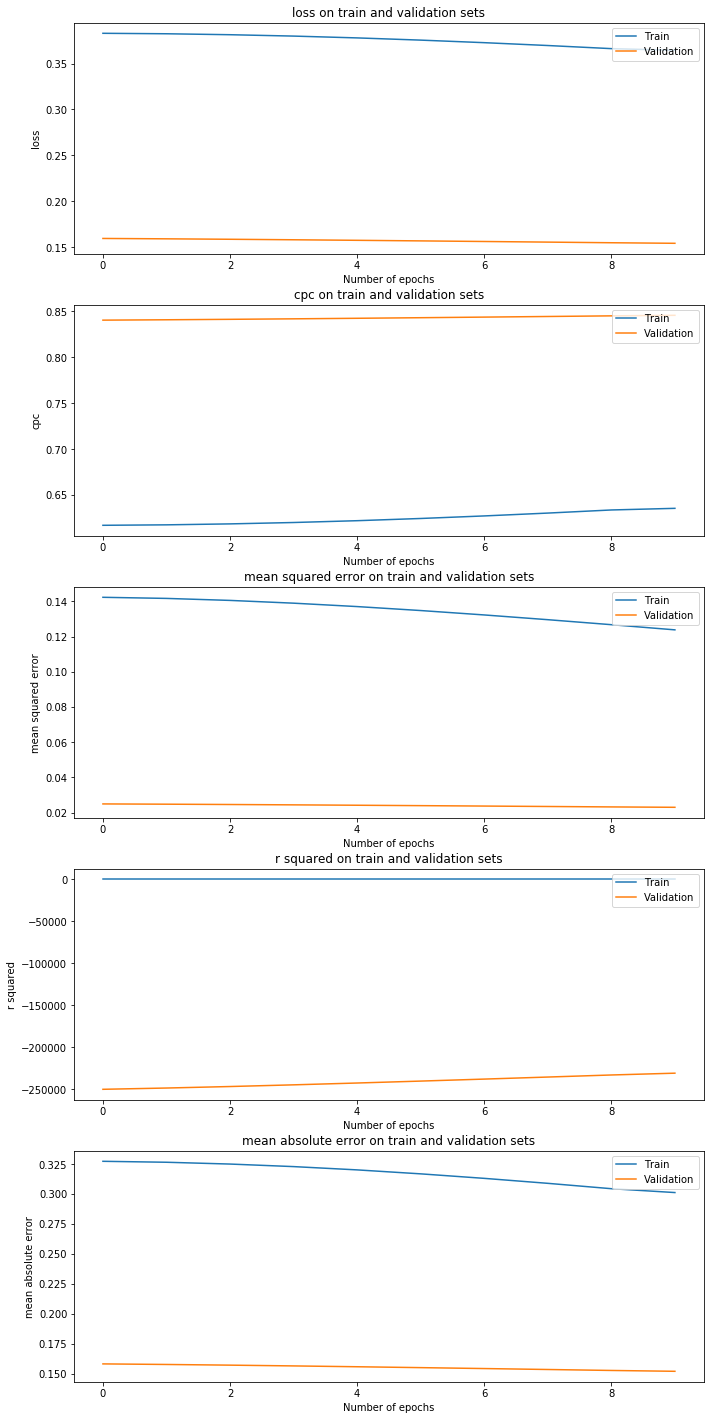

In [20]:
model_metrics = model.history.history
half = int(len(model_metrics) / 2)
val_metrics, train_metrics = list(model_metrics.keys())[:half], list(model_metrics.keys())[half:]
ratio = 10
fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
fig.tight_layout(pad=3.0)
for i in range(half):
    ax[i].set_title(train_metrics[i].replace("_", " ") + ' on train and validation sets')
    ax[i].plot(model_metrics[train_metrics[i]])
    ax[i].plot(model_metrics[val_metrics[i]])
    ax[i].set_ylabel(train_metrics[i].replace("_", " "))
    ax[i].set_xlabel('Number of epochs')
    ax[i].legend(['Train', 'Validation'], loc='upper right')

In [0]:
dataResult = evaluateBySerie(model,dataLSTM)

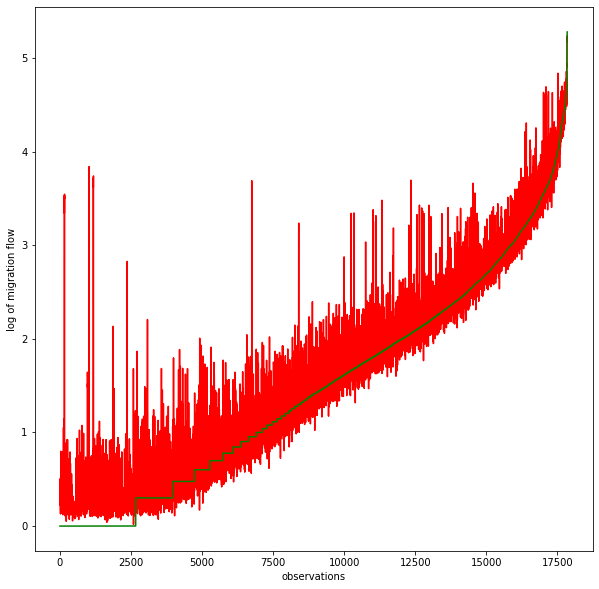

NORMALIZED TRAIN DATA :
rmse :
0.3708130086043588
mae :
0.3141895599722563
r2 :
-0.19044610274385176
cpc :
11137.814966821472

NORMALIZED TEST DATA :
rmse :
0.39729074192526204
mae :
0.3472290567815245
r2 :
-0.07056528339495194
cpc :
998.0772348260707

TOTAL TRAIN DATA :
rmse :
1475.6197724370809
mae :
235.06297417234512
r2 :
0.9178957993955771
cpc :
1442.0805679503032

TOTAL TEST DATA :
rmse :
1602.6267507690256
mae :
334.79674944309807
r2 :
0.9190000602167729
cpc :
139.15571528473677



In [24]:
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

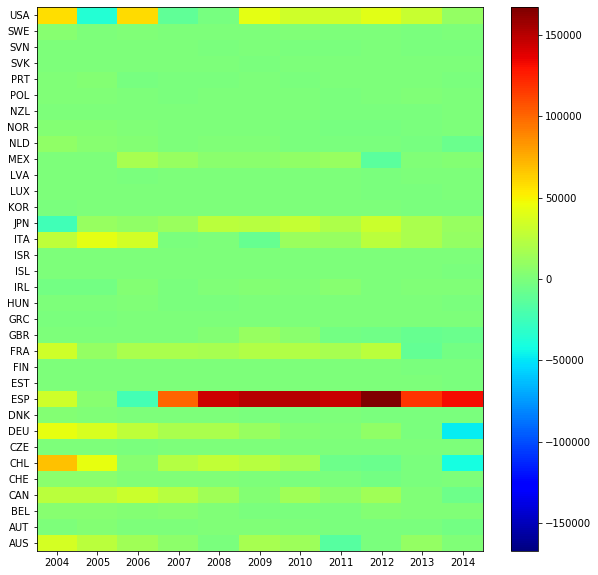

In [46]:
df = represent_year_dest(dataResult,'y_diff')

In [44]:
print(np.mean(np.abs(np.array(df))))

8732.934761873445


In [0]:
model = defineModel(dataLSTM)
train2(model, dataLSTM, verbose = 0, epoch = 10)

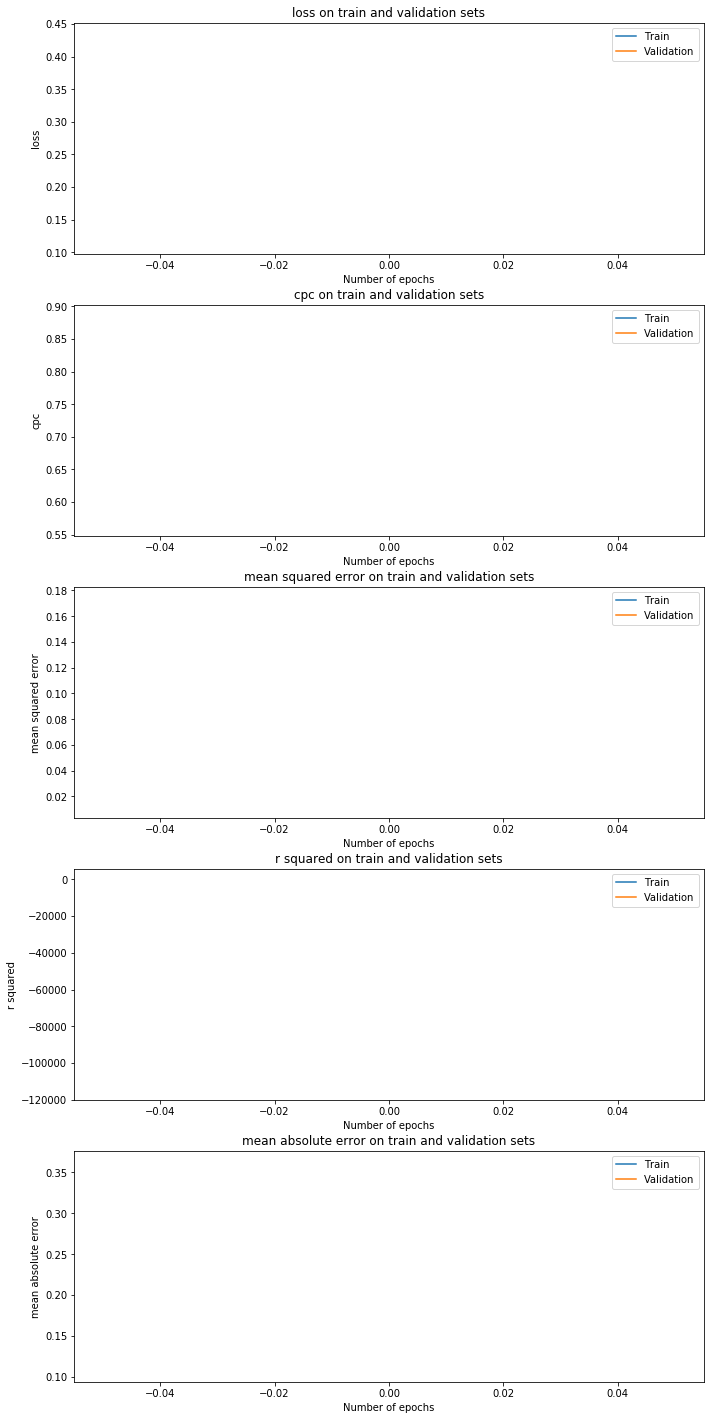

In [51]:
model_metrics = model.history.history
half = int(len(model_metrics) / 2)
val_metrics, train_metrics = list(model_metrics.keys())[:half], list(model_metrics.keys())[half:]
ratio = 10
fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
fig.tight_layout(pad=3.0)
for i in range(half):
    ax[i].set_title(train_metrics[i].replace("_", " ") + ' on train and validation sets')
    ax[i].plot(model_metrics[train_metrics[i]])
    ax[i].plot(model_metrics[val_metrics[i]])
    ax[i].set_ylabel(train_metrics[i].replace("_", " "))
    ax[i].set_xlabel('Number of epochs')
    ax[i].legend(['Train', 'Validation'], loc='upper right')

In [0]:
dataResult = evaluateBySerie(model,dataLSTM)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in log10


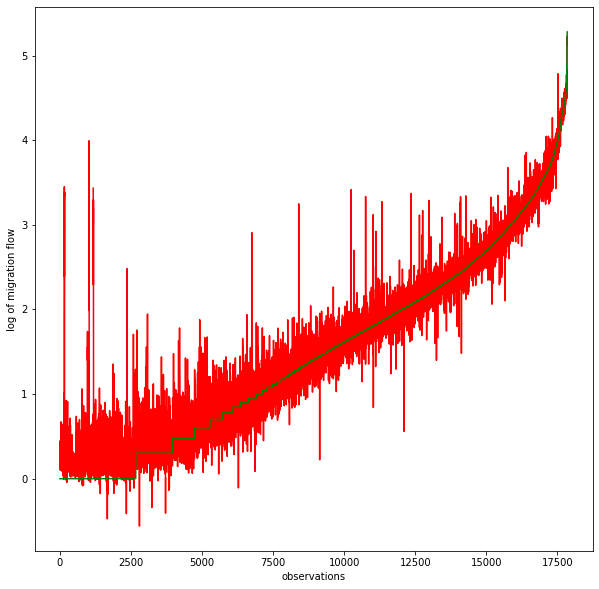

NORMALIZED TRAIN DATA :
rmse :
0.3069923204541668
mae :
0.236140752646773
r2 :
0.18406636188154013
cpc :
10348.132367677057

NORMALIZED TEST DATA :
rmse :
0.37725960826232074
mae :
0.3110878203733343
r2 :
0.0346675950315003
cpc :
929.5087552274144

TOTAL TRAIN DATA :
rmse :
862.6260344285477
mae :
126.3558217256451
r2 :
0.9719416862228389
cpc :
1433.3059818767606

TOTAL TEST DATA :
rmse :
1300.3855497448078
mae :
227.67329852107574
r2 :
0.9466709078590534
cpc :
139.47996160569446



In [53]:
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

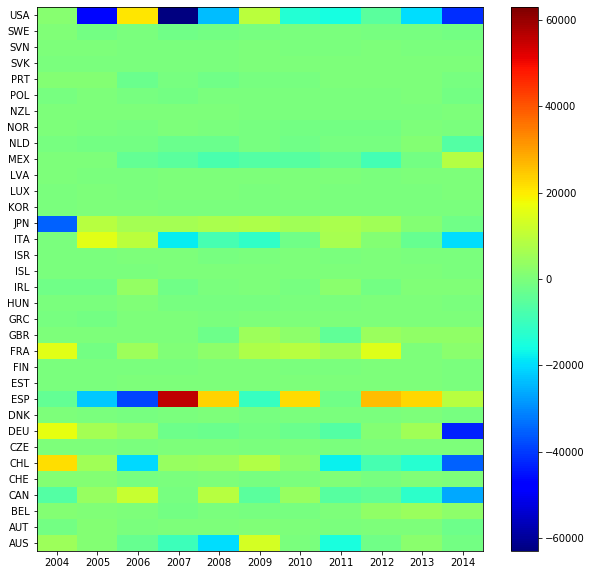

In [54]:
df = represent_year_dest(dataResult,'y_diff')

In [55]:
print(np.mean(np.abs(np.array(df))))

3577.5533094889047


#### Model with constant length of serie + cpc loss ####

In [0]:
dataLSTM = transformData(dataLSTM, min_length = 11)
model = defineModel(dataLSTM, l = cpc_loss)
train(model, dataLSTM, verbose = 0, epoch = 10)

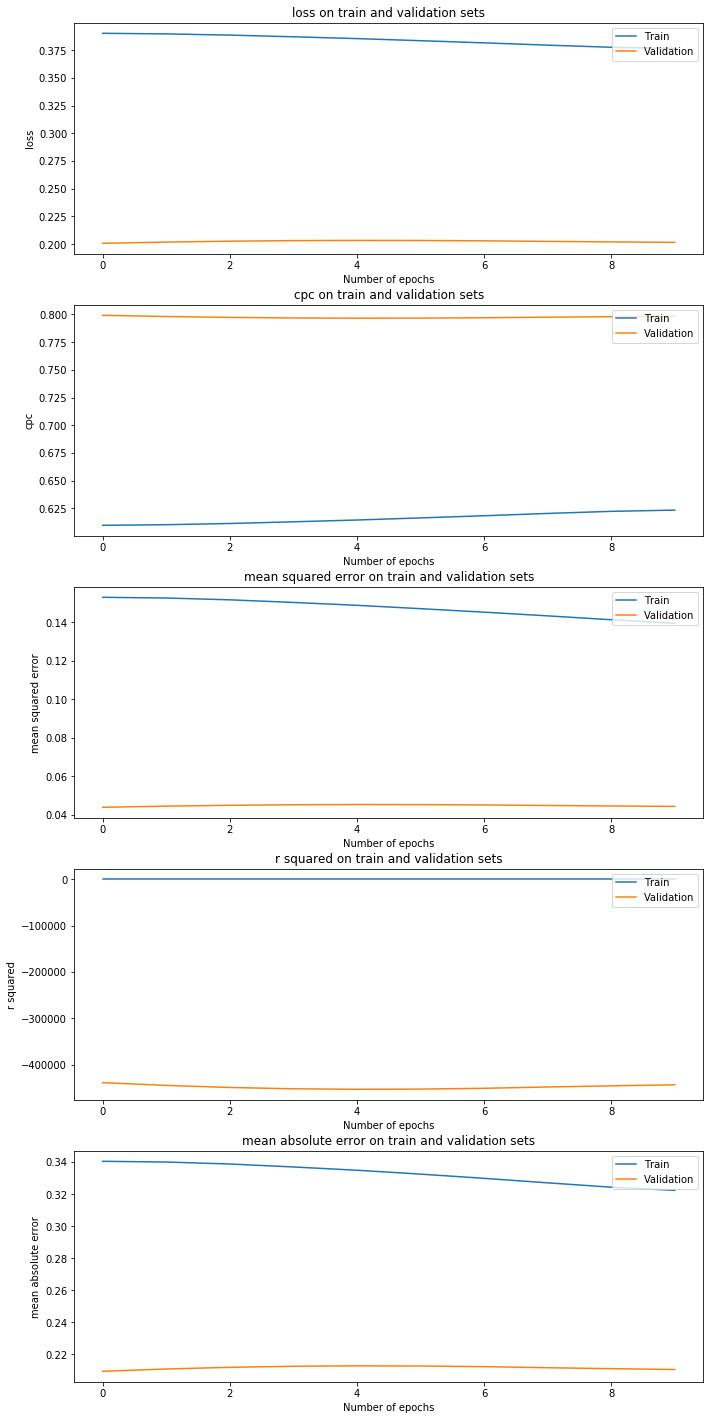

In [0]:
model_metrics = model.history.history
half = int(len(model_metrics) / 2)
val_metrics, train_metrics = list(model_metrics.keys())[:half], list(model_metrics.keys())[half:]
ratio = 10
fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
fig.tight_layout(pad=3.0)
for i in range(half):
    ax[i].set_title(train_metrics[i].replace("_", " ") + ' on train and validation sets')
    ax[i].plot(model_metrics[train_metrics[i]])
    ax[i].plot(model_metrics[val_metrics[i]])
    ax[i].set_ylabel(train_metrics[i].replace("_", " "))
    ax[i].set_xlabel('Number of epochs')
    ax[i].legend(['Train', 'Validation'], loc='upper right')

In [0]:
dataResult = evaluateBySerie(model,dataLSTM)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in log10


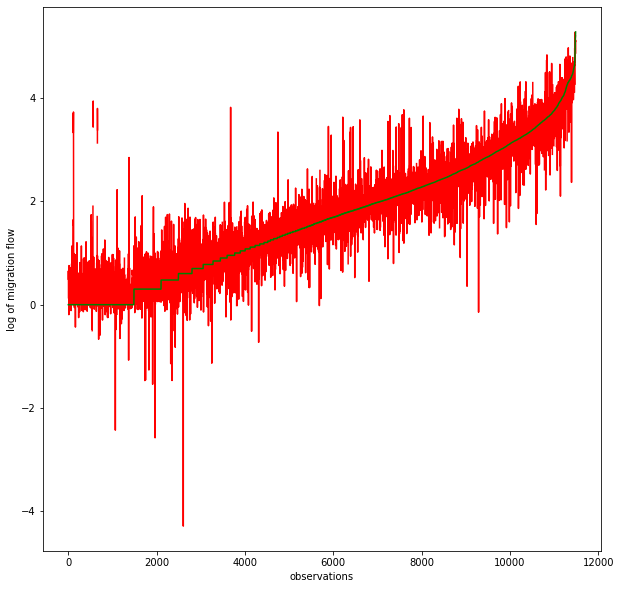

NORMALIZED TRAIN DATA :
rmse :
0.5309710331319658
mae :
0.41894810997019577
r2 :
-1.5998830522931575
cpc :
5281.324860481995

NORMALIZED TEST DATA :
rmse :
0.5897891124797934
mae :
0.47709393094115493
r2 :
-1.2838921796444223
cpc :
757.4731055444213

TOTAL TRAIN DATA :
rmse :
3660.0002294745777
mae :
635.1839179058268
r2 :
0.6503190839225371
cpc :
400.84521944489853

TOTAL TEST DATA :
rmse :
3256.258842309739
mae :
599.75914229249
r2 :
0.735399738198719
cpc :
110.1884928239909



In [0]:
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

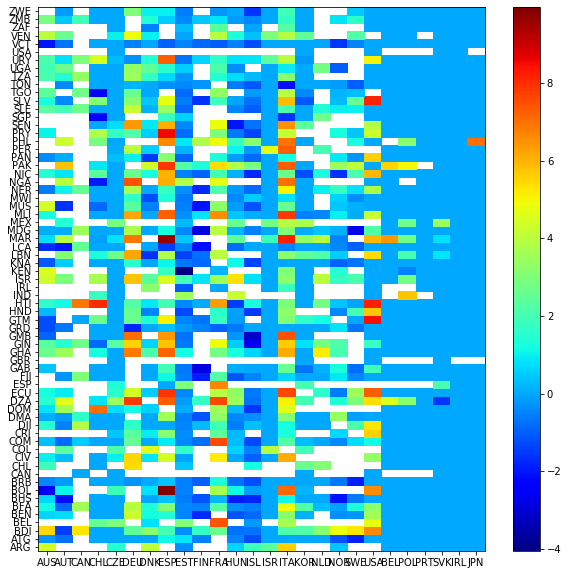

In [0]:
df = represent_origin_dest(dataResult,'y_diff')

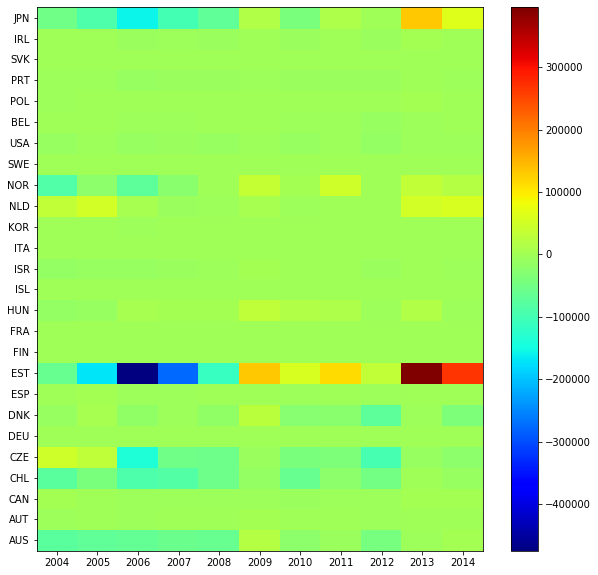

In [0]:
df = represent_year_dest(dataResult,'y_diff')

In [0]:
print(np.mean(np.abs(np.array(df))))

19639.976035273346


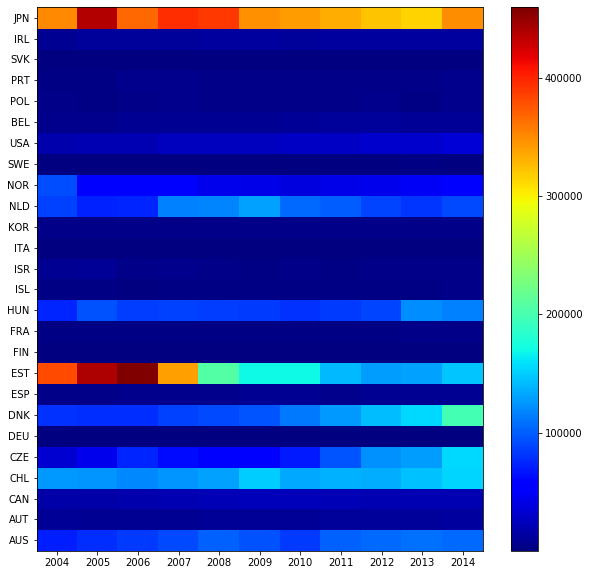

In [0]:
df = represent_year_dest(dataResult,'tot_mig')

In [0]:
print(np.mean(np.abs(np.array(df))))

53139.61966543931


#### No normalisation model ####
Pas de normalisation par série pour l'output :

In [0]:
dataLSTM,scalerY = getDataLSTM(data,norm_control_var=False)
dataLSTM = transformData(dataLSTM, min_length=2, normGTI=True, normAllX=False, normY=False)

In [0]:
model = defineModel(dataLSTM)
train(model,dataLSTM,epoch=5)

end of epoch : 0
end of epoch : 1
end of epoch : 2
end of epoch : 3
end of epoch : 4


In [0]:
dataResult = evaluateBySerie(model,dataLSTM,normBySerie=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


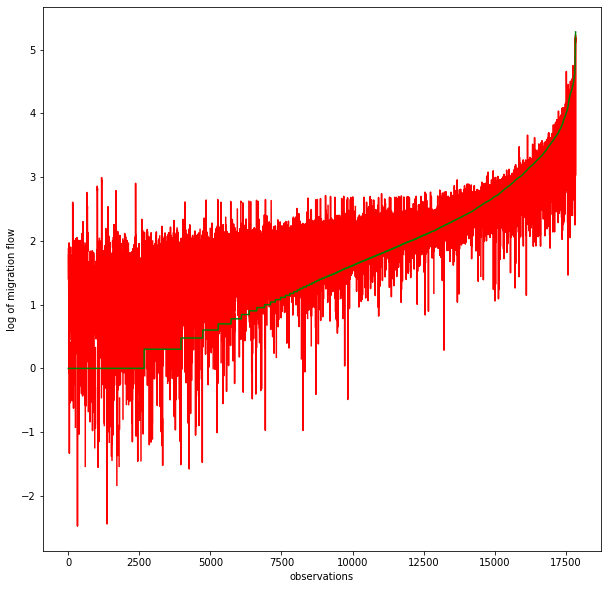

NORMALIZED TRAIN DATA :
rmse :
2064.103895943536
mae :
273.68491123339544
r2 :
0.8393504355761983
cpc :
1636.6753239794941

NORMALIZED TEST DATA :
rmse :
1369.496583629676
mae :
255.87885091436652
r2 :
0.9408517599000398
cpc :
154.52066137469765

TOTAL TRAIN DATA :
rmse :
2064.103895943536
mae :
273.68491123339544
r2 :
0.8393504355761983
cpc :
1636.6753239794941

TOTAL TEST DATA :
rmse :
1369.496583629676
mae :
255.87885091436652
r2 :
0.9408517599000398
cpc :
154.52066137469765



In [0]:
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)


#### Log model ####
On teste avec les log au lieu de normaliser

In [0]:
dataLSTMLog = getDataLSTM(data,use_log=True)
dataLSTMLog = transformData(dataLSTMLog,min_length=2,normControl= False,normY=False)

In [0]:
modelLog = defineModel(dataLSTMLog)
train(modelLog,dataLSTMLog,epoch=5)

end of epoch : 0
end of epoch : 1
end of epoch : 2
end of epoch : 3
end of epoch : 4


In [0]:
dataResultLog = evaluateBySerie(modelLog,dataLSTMLog,normBySerie=False,use_log=True)

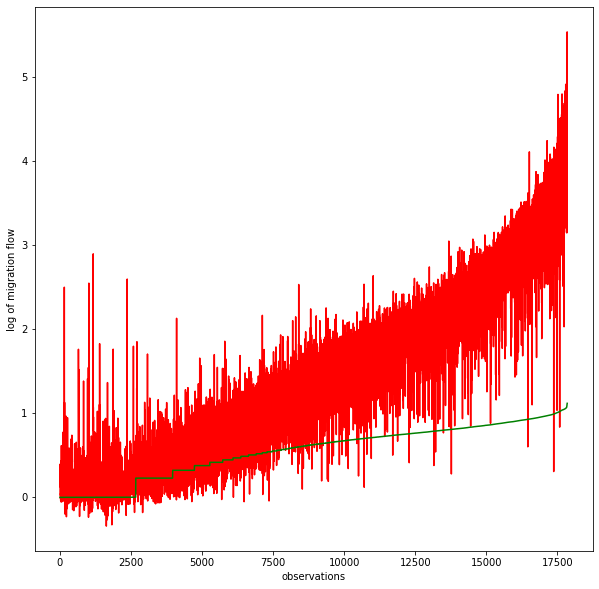

NORMALIZED TRAIN DATA :
rmse :
0.6541775855469992
mae :
0.44733075981117426
r2 :
0.936723343492967
cpc :
10207.259515992473

NORMALIZED TEST DATA :
rmse :
0.6142128537166589
mae :
0.44466006166537336
r2 :
0.9448020722075589
cpc :
899.0644173116397

TOTAL TRAIN DATA :
rmse :
7325.902806366809
mae :
825.5677144828463
r2 :
-7935502.896160949
cpc :
110.52114630652896

TOTAL TEST DATA :
rmse :
6541.212605980366
mae :
813.1918372308207
r2 :
-6260390.636672527
cpc :
10.838233682053051



In [0]:
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResultLog)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

#### Normal model with constant length of serie ####


In [0]:
dataLSTM = getDataLSTM(data)
dataLSTM = transformData(dataLSTM, min_length=11)

In [0]:
trainConstantBatch(model,dataLSTM,epoch=5)

(1149, 11, 286)
(1149, 10, 286)
(11490, 1, 286)


In [0]:
model = defineModel(dataLSTM)

trainConstantBatch(model,dataLSTM,epoch=5)

Epoch 1/5
 - 6s - loss: 0.0947
Epoch 2/5
 - 5s - loss: 0.0838
Epoch 3/5
 - 5s - loss: 0.0799
Epoch 4/5
 - 5s - loss: 0.0762
Epoch 5/5
 - 5s - loss: 0.0722


In [0]:
dataResult = evaluateBySerie(model,dataLSTM)

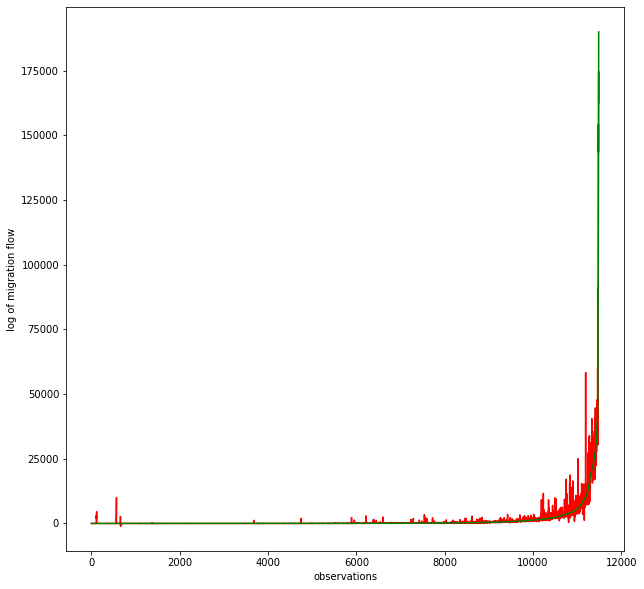

NORMALIZED TRAIN DATA :
rmse :
0.26843053073136514
mae :
0.21505051571197656
r2 :
0.33552908618207045
cpc :
6880.674616334732

NORMALIZED TEST DATA :
rmse :
0.356850260923564
mae :
0.2877640894676764
r2 :
0.16390787615761837
cpc :
664.9447367890716

TOTAL TRAIN DATA :
rmse :
1151.3245937677573
mae :
213.34547623110177
r2 :
0.9653976758940134
cpc :
1076.6856493043485

TOTAL TEST DATA :
rmse :
1564.9498054636715
mae :
296.6776552882801
r2 :
0.938884234685781
cpc :
117.14706219326924



In [0]:
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)
print('NORMALIZED TRAIN DATA :')
displayScores(train_metrics)
print('NORMALIZED TEST DATA :')
displayScores(test_metrics)
print('TOTAL TRAIN DATA :')
displayScores(total_train_metrics)
print('TOTAL TEST DATA :')
displayScores(total_test_metrics)

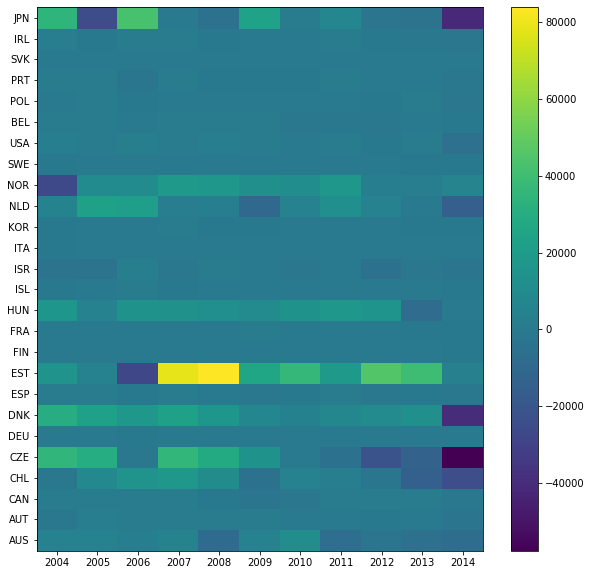

5761.450209799721


In [0]:
df = represent_year_dest(dataResult,'y_diff')
print(np.mean(np.abs(np.array(df))))

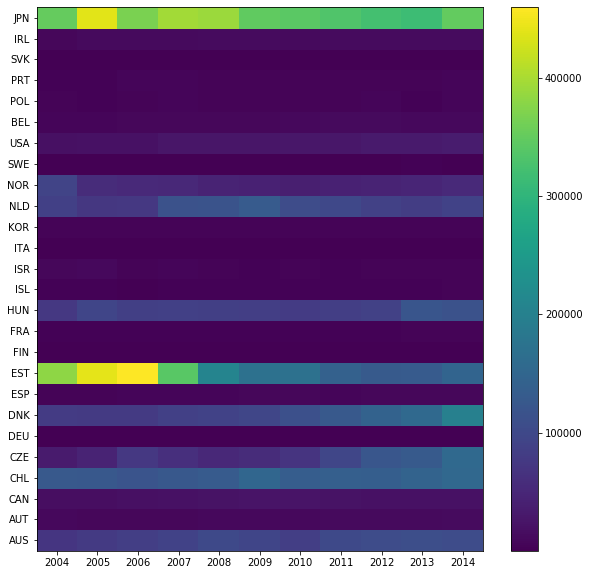

53139.61966543931


In [0]:
df = represent_year_dest(dataResult,'tot_mig')
print(np.mean(np.abs(np.array(df))))

## Anciens commentaires


pour les données de replication_bilateral.dta, le flot bilatéral min est de 0 et celui maximal est de environ 190 000. Mais la médiane est de 17, pour les quelques 24000 observations, plus de 4600 sont des observations égales à 0 !!!

Pour la suite, il faudrait calculer non pas l'erreur directe mais plutôt le pourcentage d'erreur entre une prédiction et sa valeur réelle ! En effet, calculer le rmse/mae global n'a pas d'intérêt ici vu la disparité des résultats.

In [0]:
def CPC(y,y_pred):
    return 2 * np.sum(np.minimum(y,y_pred))/(np.sum(y)+np.sum(y_pred))

def calculate_metrics(y,y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y,y_pred))
    mae = metrics.mean_absolute_error(y,y_pred)
    r2 = metrics.r2_score(y,y_pred)
    cpc = CPC(y,y_pred)
    return rmse,mae,r2,cpc


def evaluate(model,newData):
    newData['y_pred'],newData['y_real_pred'], newData['y_diff'] = None,None,None
    newData['rmse'],newData['mae'],newData['r2'],newData['cpc'] = None,None,None,None
    newData['rmse_total'],newData['mae_total'],newData['r2_total'],newData['cpc_total'] = None,None,None,None
    y_test_pred, y_test, y_train_pred, y_train = [], [], [], []
    y_real_test_pred, y_real_test, y_real_train_pred, y_real_train = [], [], [], []
    def evaluateRow(row):
        X,y,y_real = row['X'], row['y'], row['tot_mig']
        X = np.array(X).reshape((len(X), 1, len(X[0])))
        scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_real)
        y = y.reshape((len(y)))
        y_pred = model.predict(X,verbose=0)
        y_real_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred.reshape((len(y_pred)))
        row['y_pred'] = y_pred
        y_real_pred = y_real_pred.reshape((len(y_real_pred)))
        row['y_real_pred'] = y_real_pred
        row['y_diff'] = list(np.array(y_real_pred) - np.array(y_real))
        row['rmse'],row['mae'],row['r2'],row['cpc'] = calculate_metrics(y,y_pred)
        row['rmse_total'],row['mae_total'],row['r2_total'],row['cpc_total'] = calculate_metrics(y_real,y_real_pred)
        y_train_pred = list(y_pred[:-1])
        y_test_pred = [y_pred[-1]]
        y_train = list(y[:-1])
        y_test = [y[-1]]
        y_real_train_pred = list(y_real_pred[:-1])
        y_real_test_pred = [y_real_pred[-1]]
        y_real_train = list(y_real[:-1])
        y_real_test = [y_real[-1]]
        return [y_train_pred,y_test_pred,y_train,y_test,y_real_train_pred,y_real_test_pred,y_real_train,y_real_test]
    overallData = newData.apply(evaluateRow,axis=1)
    overallData = list(map(list,zip(*overallData)))
    [y_train_pred,y_test_pred,y_train,y_test,y_real_train_pred,y_real_test_pred,y_real_train,y_real_test] = [[x for el in type for x in el] for type in overallData]
    train_metrics = calculate_metrics(np.array(y_train),np.array(y_train_pred))
    test_metrics = calculate_metrics(np.array(y_test),np.array(y_test_pred))
    total_train_metrics = calculate_metrics(np.array(y_real_train),np.array(y_real_train_pred))
    total_test_metrics = calculate_metrics(np.array(y_real_test),np.array(y_real_test_pred))
    return train_metrics,test_metrics,total_train_metrics,total_test_metrics

## References ##

[1] M. H. Böhme, A. Gröger, and T. Stöhr, “Searching for a better life: Predicting international migration with online search keywords,” Journal of Development Economics, vol. 142, p. 102347, Jan. 2020, doi: 10.1016/j.jdeveco.2019.04.002.

[2] C. Robinson and B. Dilkina, “A machine learning approach to modeling human migration,” in Proceedings of the 1st ACM SIGCAS Conference on Computing and Sustainable Societies, 2018, pp. 1–8.



